# Demo:An algorithm to select the optimal maintenance dredging strategy


The basic steps to set up an OpenCLSim simulation are:
* Import libraries
* Initialise simpy environment
* Define object classes
* Create objects
  * Create sites
  * Create vessels
  * Create activities
* Register processes and run simpy

### Table of Contents
* 1. Import Libraries
* 2. Define Object Classes
* 3. Create Objects
    * 3.1. Create site object(s)
    * 3.2. Create vessel object(s)
    * 3.3. Create activity/activities
* 4. Register Processes and Run Simpy
* 5. Inspect Results

### 0. Import Libraries

In [1]:
#importing basic package(s) for time, date, and simulation
import datetime, time
import simpy

#importing packages for geographical and numerical data
import shapely.geometry

# package(s) needed for inspecting the output
import pandas as pd
import numpy as np

# package(s) related to the simulation (creating the vessel, creating objects, running the simulation)
import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot
import openclsim.plugins as plugin

# package(s) needed for plotting
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go

init_notebook_mode(connected=True)

### 1. Initialize simpy Environment

In [2]:
# setup environment (simulation time needs to match the available weather data)
simulation_start  = datetime.datetime(2010, 1, 1, 0, 0)
my_env = simpy.Environment(initial_time=simulation_start.timestamp())

### 2. Define Object Classes

In [3]:
# create a site object based on desired mixin classes
Site = type("Site", (core.Identifiable, core.Log, core.Locatable, core.HasContainer, core.HasResource),{})


# create a TransportProcessingResource object based on desired mixin classes
TransportProcessingResource = type("TransportProcessingResource", (core.Identifiable, core.Log, 
                                                                   core.ContainerDependentMovable, 
                                                                   core.Processor, core.HasResource,
                                                                   core.LoadingFunction, core.UnloadingFunction),{})

### 3. Create Objects

#### 3.1. Create site object(s)

In [4]:
# prepare input data for from_site
location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
data_from_site = {"env": my_env, "name": "from_site", "geometry": location_from_site, "capacity": 10_000,
                  "level": 10_000}

# instantiate from_site
from_site = Site(**data_from_site)


# prepare input data for to_site
location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
data_to_site = {"env": my_env, "name": "to_site", "geometry": location_to_site, "capacity": 10_000, "level": 0}

# instantiate to_site
to_site = Site(**data_to_site)

#### 3.2. Create vessel object(s)

In [5]:
# prepare input data for vessel 01
data_vessel01 = {"env": my_env, "name": "vessel01", "geometry": location_from_site, "loading_rate": 1,
                 "unloading_rate": 5, "capacity": 1_000, "compute_v": lambda x: 10 + 2 * x}

# instantiate vessel_01
vessel01 = TransportProcessingResource(**data_vessel01)

#### 3.3. Create activity/activities

In [6]:
# initialise registry
registry = {}

In [7]:
# create a list of subprocesses
sub_processes = [model.MoveActivity(env=my_env, name="sailing empty", registry=registry, mover=vessel01,
                                    destination=from_site),
                model.ShiftAmountActivity(env=my_env, name="loading", registry=registry, processor=vessel01,
                                          origin=from_site, destination=vessel01, amount=4, duration=40),
                model.MoveActivity(env=my_env, name="sailing full", registry=registry, mover=vessel01,
                                    destination=to_site),
                model.ShiftAmountActivity(env=my_env, name="unloading", registry=registry, processor=vessel01,
                                          origin=vessel01, destination=to_site, amount=4, duration=20),
                model.BasicActivity(env=my_env, name="Basic activity", registry=registry, duration=42,
                                    additional_logs=[vessel01])]


# create a basic activity (it just creates an event that shifts time for 'duration')
basic_activity = model.BasicActivity(env=my_env, name="Basic activity", registry=registry, duration=42)


# create a reporting_activity as an additional activity
reporting_activity = model.BasicActivity(env=my_env, name="Reporting activity", registry=registry, duration=5)


# create a move activity (for vessel movements)
move_activity = model.MoveActivity(env=my_env, name="Move activity", registry=registry, mover=vessel01, destination=to_site)


# create a shift amount activity (for vessel operations)
shift_amount_activity_data = model.ShiftAmountActivity(env=my_env, name="Shift amount activity", registry=registry,
                                                      processor=vessel01, origin=from_site, destination=vessel01,
                                                      amount=100, duration=60)


# create a sequential activity that is made up of the 'sub_processes'
sequential_activity = model.SequentialActivity(env=my_env, name="Sequential activity", registry=registry,
                                              sub_processes=sub_processes)


# create a while activity that executes the 'sequential activity' while the stop condition is not triggered
while_activity = model.WhileActivity(env=my_env, name="While sequential activity", registry=registry,
                                    sub_processes=[sequential_activity], 
                                    condition_event=[{"type": "container", "concept": to_site, "state": "full"}])


# create a 'repeat activity' that is made up of the 'sub_processes'
repeat_activity = model.RepeatActivity(env=my_env, name="Repeat activity", registry=registry, sub_processes=sub_processes,
                                       repetitions=3)


# create a parallel activity
parallel_activity = model.ParallelActivity(env= my_env, name= "Parallel process", registry= registry,
                                           sub_processes= sub_processes)

# create a 'while activity' that contains a pre-packed set of 'sub_processes'
single_run, while_activity  = model.single_run_process(name="single_run", registry={}, env=my_env, origin=from_site,
    destination=to_site, mover=vessel01, loader=vessel01, unloader=vessel01)



### 4. Register Processes and Run simpy

In [8]:
# initiate the simpy processes defined in the 'while_activity' and run simpy
model.register_processes([while_activity])
my_env.run()

### 5. Inspect Results

#### 5.1. Inspect logs
The method plot.get_log_dataframe returns the log of an activity in the form of a dataframe. By adding other activities in a list as the second argument, the Activity can be made more human readable.

In [9]:
display(plot.get_log_dataframe(vessel01, [*single_run, while_activity]))

,Activity,Timestamp,ActivityState,geometry,container level
0,single_run sailing empty,2009-12-31 23:00:00.000000,START,POINT (4.18055556 52.18664444),0.0
1,single_run sailing empty,2009-12-31 23:00:00.000000,STOP,POINT (4.18055556 52.18664444),0.0
2,single_run loading,2009-12-31 23:00:00.000000,START,POINT (4.18055556 52.18664444),0.0
3,single_run loading,2009-12-31 23:16:40.000000,STOP,POINT (4.18055556 52.18664444),1000.0
4,single_run sailing filled,2009-12-31 23:16:40.000000,START,POINT (4.18055556 52.18664444),1000.0
...,...,...,...,...,...
75,single_run loading,2010-01-01 06:35:56.605754,STOP,POINT (4.18055556 52.18664444),1000.0
76,single_run sailing filled,2010-01-01 06:35:56.605754,START,POINT (4.18055556 52.18664444),1000.0
77,single_run sailing filled,2010-01-01 06:49:02.292913,STOP,POINT (4.25222222 52.11428333),1000.0
78,single_run unloading,2010-01-01 06:49:02.292913,START,POINT (4.25222222 52.11428333),1000.0


In [10]:
display(plot.get_log_dataframe(from_site, [*single_run]))

,Activity,Timestamp,ActivityState,container level,geometry
0,single_run loading,2009-12-31 23:00:00.000000,START,10000.0,POINT (4.18055556 52.18664444)
1,single_run loading,2009-12-31 23:16:40.000000,STOP,9000.0,POINT (4.18055556 52.18664444)
2,single_run loading,2009-12-31 23:48:48.511750,START,9000.0,POINT (4.18055556 52.18664444)
3,single_run loading,2010-01-01 00:05:28.511750,STOP,8000.0,POINT (4.18055556 52.18664444)
4,single_run loading,2010-01-01 00:37:37.023501,START,8000.0,POINT (4.18055556 52.18664444)
5,single_run loading,2010-01-01 00:54:17.023501,STOP,7000.0,POINT (4.18055556 52.18664444)
6,single_run loading,2010-01-01 01:26:25.535251,START,7000.0,POINT (4.18055556 52.18664444)
7,single_run loading,2010-01-01 01:43:05.535251,STOP,6000.0,POINT (4.18055556 52.18664444)
8,single_run loading,2010-01-01 02:15:14.047002,START,6000.0,POINT (4.18055556 52.18664444)
9,single_run loading,2010-01-01 02:31:54.047002,STOP,5000.0,POINT (4.18055556 52.18664444)


In [11]:
display(plot.get_log_dataframe(to_site, [*single_run]))

,Activity,Timestamp,ActivityState,container level,geometry
0,single_run unloading,2009-12-31 23:29:45.687159,START,0.0,POINT (4.25222222 52.11428333)
1,single_run unloading,2009-12-31 23:33:05.687159,STOP,1000.0,POINT (4.25222222 52.11428333)
2,single_run unloading,2010-01-01 00:18:34.198910,START,1000.0,POINT (4.25222222 52.11428333)
3,single_run unloading,2010-01-01 00:21:54.198910,STOP,2000.0,POINT (4.25222222 52.11428333)
4,single_run unloading,2010-01-01 01:07:22.710660,START,2000.0,POINT (4.25222222 52.11428333)
5,single_run unloading,2010-01-01 01:10:42.710660,STOP,3000.0,POINT (4.25222222 52.11428333)
6,single_run unloading,2010-01-01 01:56:11.222411,START,3000.0,POINT (4.25222222 52.11428333)
7,single_run unloading,2010-01-01 01:59:31.222411,STOP,4000.0,POINT (4.25222222 52.11428333)
8,single_run unloading,2010-01-01 02:44:59.734161,START,4000.0,POINT (4.25222222 52.11428333)
9,single_run unloading,2010-01-01 02:48:19.734161,STOP,5000.0,POINT (4.25222222 52.11428333)


In [12]:
plot.get_gantt_chart([while_activity, vessel01, *single_run])

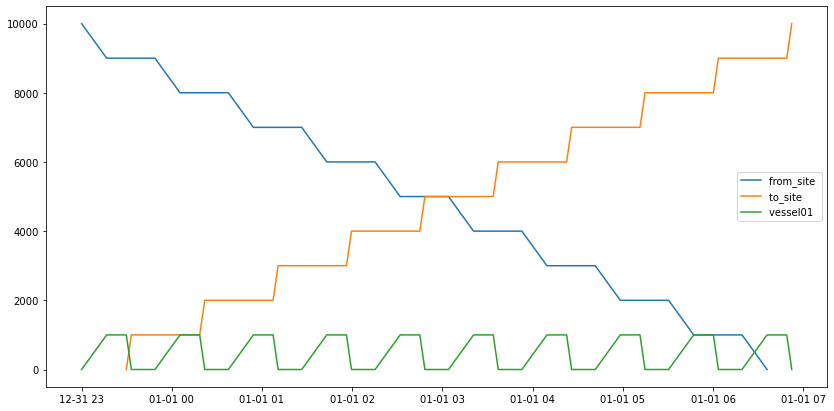

In [13]:
fig = plot.get_step_chart([from_site, to_site, vessel01])

You can observe in the step chart that the loading rate of vessel01 is 1 and the unloading rate is 5. This is clearly visible in the longer time it takes to transfer the cargo from from_site to vessel01, than it takes to transfer the cargo from vessel_1 to to_site.

In [14]:
pd.DataFrame.from_dict(vessel01.log)

,Timestamp,ActivityID,ActivityState,ObjectState,ActivityLabel
0,2009-12-31 23:00:00.000000,c1d3541a-bd03-44fb-ad34-8e4c0f62a7a5,START,"{'geometry': POINT (4.18055556 52.18664444), '...",{}
1,2009-12-31 23:00:00.000000,c1d3541a-bd03-44fb-ad34-8e4c0f62a7a5,STOP,"{'geometry': POINT (4.18055556 52.18664444), '...",{}
2,2009-12-31 23:00:00.000000,9bd69824-b964-4c69-af69-027442edec26,START,"{'geometry': POINT (4.18055556 52.18664444), '...",{}
3,2009-12-31 23:16:40.000000,9bd69824-b964-4c69-af69-027442edec26,STOP,"{'geometry': POINT (4.18055556 52.18664444), '...",{}
4,2009-12-31 23:16:40.000000,a3efcc48-6b8e-49b5-a7f9-ce3577b96e8a,START,"{'geometry': POINT (4.18055556 52.18664444), '...",{}
...,...,...,...,...,...
75,2010-01-01 06:35:56.605754,9bd69824-b964-4c69-af69-027442edec26,STOP,"{'geometry': POINT (4.18055556 52.18664444), '...",{}
76,2010-01-01 06:35:56.605754,a3efcc48-6b8e-49b5-a7f9-ce3577b96e8a,START,"{'geometry': POINT (4.18055556 52.18664444), '...",{}
77,2010-01-01 06:49:02.292913,a3efcc48-6b8e-49b5-a7f9-ce3577b96e8a,STOP,"{'geometry': POINT (4.25222222 52.11428333), '...",{}
78,2010-01-01 06:49:02.292913,d747cb88-cae4-4cdb-94c5-9eeb7f154a98,START,"{'geometry': POINT (4.25222222 52.11428333), '...",{}


In [15]:
list(set(vessel01.log["ActivityID"]))

['c1d3541a-bd03-44fb-ad34-8e4c0f62a7a5',
 'a3efcc48-6b8e-49b5-a7f9-ce3577b96e8a',
 '9bd69824-b964-4c69-af69-027442edec26',
 'd747cb88-cae4-4cdb-94c5-9eeb7f154a98']